Microsoft Malware detection

Student: Yashwant Bhaidkar

Organization: Applied Roots

In recent years, the landscape of the malware industry has undergone a significant transformation, evolving into a highly organized market characterized by well-funded syndicates. These groups invest heavily in technologies and capabilities designed to circumvent traditional protection measures, necessitating continuous innovation in anti-malware solutions. Microsoft, a major player in this space, has acknowledged the escalating threat and taken a proactive stance by addressing one of the key challenges faced by the industry.

One major obstacle in the battle against malware is the vast volume of data and files that demand evaluation for potential malicious intent. Microsoft's real-time detection anti-malware products are deployed on over 160 million computers globally, inspecting more than 700 million computers monthly. This immense scale generates tens of millions of daily data points, each representing a potential instance of malware.

The primary reason behind the staggering number of different files is the use of polymorphism by malware authors. To evade detection, malicious files within the same malware "family" exhibit constant modification and obfuscation through various tactics, making them appear as numerous distinct files.

To effectively analyze and classify such a large volume of files, there is a need to group them based on common characteristics and identify their respective families. Moreover, these grouping criteria can be applied to newly encountered files to detect them as malicious and associate them with a specific family.

In response to this challenge, Microsoft has taken a groundbreaking step by providing the data science community with an unprecedented malware dataset. This initiative aims to foster open-source collaboration and encourages progress in developing techniques for grouping variants of malware files into their respective families. The goal is to leverage collective expertise and innovation to stay ahead of the dynamic and evolving nature of cyber threats. This collaborative approach reflects a recognition of the importance of a united front in tackling the complexities posed by modern malware.

The evalution is done on the basis of multi class log loss

In [ ]:
!pip install kaggle
from google.colab import files
from datetime import datetime
api_token = files.upload()

Saving kaggle.json to kaggle.json


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import os
from csv import writer
import array
import codecs
from sklearn.feature_extraction.text import CountVectorizer
import scipy
from lightgbm import LGBMClassifier

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c 'malware-classification'

  0% 0.00/265k [00:00<?, ?B/s]
100% 265k/265k [00:00<00:00, 40.2MB/s]
  0% 0.00/185k [00:00<?, ?B/s]
100% 185k/185k [00:00<00:00, 59.9MB/s]
100% 17.5G/17.5G [05:01<00:00, 97.2MB/s]
100% 17.5G/17.5G [05:01<00:00, 62.3MB/s]
 74% 3.00M/4.06M [00:00<00:00, 19.9MB/s]
100% 4.06M/4.06M [00:00<00:00, 25.9MB/s]
100% 17.8G/17.8G [05:29<00:00, 101MB/s]
100% 17.8G/17.8G [05:29<00:00, 57.8MB/s]


In [ ]:
# Keep only train.7z, trainLables files remove other files as shown below
!rm test.7z
!rm sampleSubmission.csv.zip
!rm dataSample.7z

In [ ]:
# 
data=!7z l train.7z
print(len(data))
print(type(data))

21759
<class 'IPython.utils.text.SList'>


In [ ]:
byte_file_list=[]
asm_file_list=[]
for i in data:
  if (i.endswith("bytes")):
    byte_file_list.append(i)
  elif (i.endswith("asm")):
    asm_file_list.append(i)



In [ ]:
print('Number of Byte files',len(byte_file_list))

Number of Byte files 10868


In [ ]:
print('Number of ASM files',len(asm_file_list))

Number of ASM files 10868


In [ ]:
byte_file_list[0]

'2015-01-29 05:00:00 ....A      5256192               train/01azqd4InC7m9JpocGv5.bytes'

In [ ]:
# Removing extra character and to get only the file name 
(byte_file_list[0].split()[-1]).replace('train/', '')

'01azqd4InC7m9JpocGv5.bytes'

In [ ]:
# Doing the same operation for all the files
byte_file_name=[]
for i in range(0,len(byte_file_list)):
  byte_file_name.append(byte_file_list[i].split()[-1].replace('train/', ''))

In [ ]:
byte_file_name[:3]


['01azqd4InC7m9JpocGv5.bytes',
 '01IsoiSMh5gxyDYTl4CB.bytes',
 '01jsnpXSAlgw6aPeDxrU.bytes']

In [ ]:
# Finding only the file names of ASM files and storing the file names in an array
asm_file_name=[]
for i in range(0,len(asm_file_list)):
  asm_file_name.append(asm_file_list[i].split()[-1].replace('train/', ''))

In [ ]:
asm_file_name[:3]

['01azqd4InC7m9JpocGv5.asm',
 '01IsoiSMh5gxyDYTl4CB.asm',
 '01jsnpXSAlgw6aPeDxrU.asm']

In [ ]:
import os
# Getting the current working directory
os.getcwd()

'/content'

In [ ]:
os.listdir()

['.config',
 'gdrive',
 'trainLabels.csv',
 'kaggle.json',
 'train.7z',
 'sample_data']

In [ ]:
byte_file_name[0]

'01azqd4InC7m9JpocGv5.bytes'

In [ ]:
# Downloading only a single byte file from train.7z
%%time
file_name=byte_file_name[0]
!7z e train.7z -o/content *$file_name -r

In [ ]:
# Deleting the file
os.remove(file_name)

In [ ]:
!mkdir bytefiles

In [ ]:
#To download all the byte files from train.7z and below code will take almost 15mins.
start=datetime.now()

!7z e train.7z -o/content/gdrive/MyDrive/bytefiles *.bytes -r

end=datetime.now()
difference=end-start
print('Time taken to extract all the byte files',difference)



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,40 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 18810691091 bytes (18 GiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 18810691091
Headers Size = 339764
Method = LZMA:24
Solid = +
Blocks = 94

  0%      0% . train/kQEbWRHa04gOYDqM1NJ6.asm                                       0% 1 . train/KqEgONxfHdP5lLaBIGQk.asm                                         0% 2 . train/kqiOdVbRQlB2s907GLMv.asm                                         0% 5 . train/kQsiVxDbAXt23wRWal57.asm

In [ ]:
print('Number of byte files extracted is',len(os.listdir('/content/gdrive/MyDrive/bytefiles/')))

Number of byte files extracted is 10868


size feature

In [ ]:
#https://www.thepythoncode.com/article/get-directory-size-in-bytes-using-python

def get_directory_size(directory):
    """Returns the `directory` size in bytes."""
    total = 0
    try:
        # print("[+] Getting the size of", directory)
        for entry in os.scandir(directory):
            if entry.is_file():
                # if it's a file, use stat() function
                total += entry.stat().st_size
            elif entry.is_dir():
                # if it's a directory, recursively call this function
                total += get_directory_size(entry.path)
    except NotADirectoryError:
        # if `directory` isn't a directory, get the file size then
        return os.path.getsize(directory)
    except PermissionError:
        # if for whatever reason we can't open the folder, return 0
        return 0
    return total

In [ ]:
def get_size_format(b, factor=1024, suffix="B"):
    """
    Scale bytes to its proper byte format
    e.g:
        1253656 => '1.20MB'
        1253656678 => '1.17GB'
    """
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        if b < factor:
            return f"{b:.2f}{unit}{suffix}"
        b /= factor
    return f"{b:.2f}Y{suffix}"

In [ ]:
get_size_format(get_directory_size("bytefiles/"))

In [ ]:
import pandas as pd
Y= pd.read_csv("trainLabels.csv")
total = len(Y)*1.

In [ ]:
#file sizes of byte files

files=os.listdir('bytefiles/')
filenames=Y['Id'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('bytefiles/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
data_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes})
print (data_size_byte.head())

In [ ]:
class_bytes

In [ ]:
len(data_size_byte)

In [ ]:
files = os.listdir('/content/gdrive/MyDrive/bytefiles')

In [ ]:
len(files)

10868

In [ ]:
import numpy as np
from tqdm import tqdm
#removal of addres from byte files
# contents of .byte files
# ----------------
#00401000 56 8D 44 24 08 50 8B F1 E8 1C 1B 00 00 C7 06 08 
#-------------------
#we remove the starting address 00401000

files = os.listdir('/content/gdrive/MyDrive/bytefiles')
filenames=[]
array=[]
for file in tqdm(files):
    if(file.endswith("bytes")):
        file=file.split('.')[0]
        text_file = open('/content/gdrive/MyDrive/bytefiles/'+file+".txt", 'w+')
        with open('/content/gdrive/MyDrive/bytefiles/'+file+".bytes","r") as fp:
            lines=""
            for line in fp:
                a=line.rstrip().split(" ")[1:]
                b=' '.join(a)
                b=b+"\n"
                text_file.write(b)
            fp.close()
            os.remove('/content/gdrive/MyDrive/bytefiles/'+file+".bytes")
        text_file.close()

files = os.listdir('/content/gdrive/MyDrive/bytefiles')
filenames2=[]
feature_matrix = np.zeros((len(files),257),dtype=int)
k=0

100%|██████████| 10868/10868 [1:35:55<00:00,  1.89it/s]



In [ ]:
len(files)

10868

In [ ]:
# def get_bigrams(file):
#   temp_list = []
#   with open('bytefiles/'+file,"r") as byte_flie:
#     all_lines = []
#     for lines in byte_flie:
#       line=lines.rstrip().split(" ")
#       all_lines.extend(line)
#       bi_g = [' '.join(x) for x in list(ngrams(all_lines, 2))]
#     for hex_code in bi_g:
#       temp_list.append(hex_code.lower())
#       temp_list = list(set(temp_list))
#   return temp_list

In [ ]:
# all_keys= []
# from tqdm import tqdm
# for file in tqdm(files):
#   all_keys.append(get_bigrams(file))
#   all_keys = list(set(all_keys))
# len(all_keys)

Byte file bigram feature

In [ ]:
a="00,01,02,03,04,05,06,07,08,09,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16\
,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,\
32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4\
d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68\
,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,\
84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9\
f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba\
,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,\
d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f\
1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??"
# a = a.replace(",", " ")
# a_uni = a.split(" ")

In [ ]:
bi_g = []
# from nltk.util import ngrams
# for i in range(0,len(a_uni)):
#   for j in range(0,len(a_uni)):
#     bi_g.append(a_uni[i]+' '+a_uni[j])
for i, j in enumerate(a.split(',')):
  for k in range(0, len(a.split(','))):
    bi_g.append(j + ' ' +a.split(',')[k])
len(bi_g)

66049

In [ ]:
# import scipy
# from sklearn.feature_extraction.text import CountVectorizer
# from scipy.sparse import csr_matrix
# def bigram_feature(files):
#   #k = 0
#   pid = os.getpid()
#   string_pid = str(pid)
#   #filelength = len(files)
#   # byte_feature_file=open('result'+string_pid+'.csv','w+')
#   # byte_feature_file.write("ID,"+','.join(bi_g))
#   # byte_feature_file.write("\n")
#   vector = CountVectorizer(lowercase = False,ngram_range = (2,2), vocabulary = bi_g)
#   mat = csr_matrix((len(files), len(bi_g)))
#   for i,file in enumerate(files):
#     f = open('bytefiles/' + file)

#     #filenames2.append(file)
#     #byte_feature_file.write(file+",")
#     # if(file.endswith("bytes")):
#     #   with open('bytefiles/'+file,"r") as byte_file:
#     mat[i, :] += csr_matrix(vector.fit_transform([f.read().replace('\n', ' ').lower()]))
#       # #byte_feature_file.write(file.split(".")[0]+",")
#       #   for lines in byte_flie:
#       #     line = lines.rstrip().split(" ")
#       #     l  = [' '.join(x) for x in list(ngrams(line, 2))]
#       #     for i in range(0,len(l)): # line by line match is taking to much time to read the file henceshifting to vector calculation
#       #       for j in range(0,len(bi_g)):
#       #         if l[i] in bi_g[j]:
#       #           feature_matrix2[k][j] +=
      

#     f.close()
#     print(pid,i+1,'files processed')
#       # print("file"+str(k)+"Processed")
# #   for i in feature_matrix2[k]:
# #     byte_feature_file.write(str(i)+",")
# #   byte_feature_file.write("\n")
# #   k += 1
#   filename = 'bigram_'+string_pid+'.npz'
#   scipy.sparse.save_npz(filename, mat)#'bytebigram.npz'


# # byte_feature_file.close()

In [ ]:
import scipy 
from scipy.sparse import csr_matrix
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
def bigrams_features(files):

  pid = os.getpid()
  print('Process started with id = ', pid)
  ftot = len(files)
  id = []
  str_pid = str(pid)
  vector_str_pid = CountVectorizer(lowercase=False,ngram_range=(2,2), vocabulary=bi_g)
  bytebigram_vect_str_pid = csr_matrix((len(files), len(bi_g)))
  print('vector created ', 'bigram_vect', '_', str_pid)
  for i, file in enumerate(files):
    f = open('/content/gdrive/MyDrive/bytefiles/' + file)
    bytebigram_vect_str_pid[i, :] += csr_matrix(vector_str_pid.fit_transform([f.read().replace('\n', ' ').lower()]))
    id.append(file.split('.')[0])
    f.close()
    print(pid, i + 1, 'of', ftot, 'files processed.')
  filename = 'bigram_'+str_pid+'.npz'
  scipy.sparse.save_npz(filename, bytebigram_vect_str_pid)#'bytebigram.npz'
  return id

In [ ]:
# from multiprocessing import Pool  #creating null files
# files = os.listdir('bytefiles')
# q = int(len(files)/11)
# t1 = files[:q]
# t2 = files[q:(2*q)]
# t3 = files[(2*q):(3*q)]
# t4 = files[(3*q):(4*q)]
# t5 = files[(4*q):(5*q)]
# t6 = files[(5*q):(6*q)]
# t7 = files[(6*q):(7*q)]
# t8 = files[(7*q):(8*q)]
# t9 = files[(8*q):(9*q)]
# t10 = files[(9*q):(10*q)]
# t11 = files[(10*q):]
# t = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11]
# p = Pool(11)
# p.map(bigram_feature,t)

In [ ]:
# from multiprocessing import Pool
# files = os.listdir('bytefiles')
# q = int(len(files)/4)
# t1 = files[:q]
# t2 = files[q:(2*q)]
# t3 = files[(2*q):(3*q)]
# t4 = files[(3*q):]
# t = [t1,t2,t3,t4]
# p = Pool(4)
# p.map(bigram_feature,t)

In [ ]:
%%time
from multiprocessing import Pool
files = os.listdir('/content/gdrive/MyDrive/bytefiles')
q = int(len(files)/22)
t1 = files[:q]
t2 = files[q:(2*q)]
t3 = files[(2*q):(3*q)]
t4 = files[(3*q):(4*q)]
t5 = files[(4*q):(5*q)]
t6 = files[(5*q):(6*q)]
t7 = files[(6*q):(7*q)]
t8 = files[(7*q):(8*q)]
t9 = files[(8*q):(9*q)]
t10 = files[(9*q):(10*q)]
t11 = files[(10*q):(11*q)]
t12 = files[(11*q):(12*q)]
t13 = files[(12*q):(13*q)]
t14 = files[(13*q):(14*q)]
t15 = files[(14*q):(15*q)]
t16 = files[(15*q):(16*q)]
t17 = files[(16*q):(17*q)]
t18 = files[(17*q):(18*q)]
t19 = files[(18*q):(19*q)]
t20 = files[(19*q):(20*q)]
t21 = files[(20*q):(21*q)]
t22 = files[(21*q):]
t = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22]
p = Pool(22)
id1,id2,id3,id4,id5,id6,id7,id8,id9,id10,id11,id12,id13,id14,id15,id16,id17,id18,id19,id20,id21,id22 = p.map(bigrams_features,t)

Process started with id =  595
Process started with id =  594
Process started with id =  597
Process started with id =  596
Process started with id =  598
Process started with id =  599
Process started with id =  601
Process started with id =  600
Process started with id =  602
Process started with id =  606
Process started with id =  603
Process started with id =  605
Process started with id =  608
Process started with id =  607
Process started with id =  609
Process started with id =  604
Process started with id =  610
Process started with id =  614
Process started with id =  611
Process started with id =  612
Process started with id =  613
Process started with id =  615
vector created  bigram_vect _ 594
vector created  bigram_vect _ 607
vector created  bigram_vect _ 606
vector created  bigram_vect _ 598
vector created  bigram_vect _ 600
vector created  bigram_vect _ 605
vector created  bigram_vect _ 602
vector created  bigram_vect _ 596
vector created  bigram_vect _ 601
vector creat

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


604 1 of 494 files processed.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


596 1 of 494 files processed.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


612 1 of 494 files processed.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


610 1 of 494 files processed.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


608 1 of 494 files processed.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


609 1 of 494 files processed.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


597 1 of 494 files processed.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


611 1 of 494 files processed.
596 2 of 494 files processed.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


603 1 of 494 files processed.
604 2 of 494 files processed.
596 3 of 494 files processed.
597 2 of 494 files processed.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


614 1 of 494 files processed.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


605 1 of 494 files processed.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


602 1 of 494 files processed.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


615 1 of 494 files processed.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


599 1 of 494 files processed.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


606 1 of 494 files processed.
596 4 of 494 files processed.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


594 1 of 494 files processed.
608 2 of 494 files processed.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


600 1 of 494 files processed.
612 2 of 494 files processed.
615 2 of 494 files processed.
609 2 of 494 files processed.
604 3 of 494 files processed.
596 5 of 494 files processed.
611 2 of 494 files processed.
604 4 of 494 files processed.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


601 1 of 494 files processed.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


613 1 of 494 files processed.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


598 1 of 494 files processed.
596 6 of 494 files processed.
611 3 of 494 files processed.
614 2 of 494 files processed.
604 5 of 494 files processed.
615 3 of 494 files processed.
610 2 of 494 files processed.
609 3 of 494 files processed.
613 2 of 494 files processed.
603 2 of 494 files processed.
605 2 of 494 files processed.
599 2 of 494 files processed.
597 3 of 494 files processed.
602 2 of 494 files processed.
614 3 of 494 files processed.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


595 1 of 494 files processed.
611 4 of 494 files processed.
609 4 of 494 files processed.
612 3 of 494 files processed.
606 2 of 494 files processed.
596 7 of 494 files processed.
608 3 of 494 files processed.
600 2 of 494 files processed.
594 2 of 494 files processed.
614 4 of 494 files processed.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Streaming output truncated to the last 5000 lines.
601 272 of 494 files processed.
596 266 of 494 files processed.
615 274 of 494 files processed.
603 281 of 494 files processed.
610 284 of 494 files processed.
606 267 of 494 files processed.
607 274 of 494 files processed.
609 286 of 494 files processed.
595 281 of 494 files processed.
613 255 of 494 files processed.
599 259 of 494 files processed.
612 255 of 494 files processed.
608 256 of 494 files processed.
596 267 of 494 files processed.
603 282 of 494 files processed.
597 272 of 494 files processed.
614 245 of 494 files processed.
600 275 of 494 files processed.
607 275 of 494 files processed.
611 265 of 494 files processed.
612 256 of 494 files processed.
613 256 of 494 files processed.
597 273 of 494 files processed.
604 263 of 494 files processed.
605 254 of 494 files processed.
594 254 of 494 files processed.
598 272 of 494 files processed.
606 268 of 494 files processed.
602 282 of 494 files processed.
609 287 of 494 files 

In [ ]:
import scipy
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
vect_1 =scipy.sparse.load_npz('bigram_594.npz')
vect_2 =scipy.sparse.load_npz('bigram_595.npz')
vect_3 =scipy.sparse.load_npz('bigram_596.npz')
vect_4 =scipy.sparse.load_npz('bigram_597.npz')
vect_5 =scipy.sparse.load_npz('bigram_598.npz')
vect_6 =scipy.sparse.load_npz('bigram_599.npz')
vect_7 =scipy.sparse.load_npz('bigram_600.npz')
vect_8 =scipy.sparse.load_npz('bigram_601.npz')
vect_9 =scipy.sparse.load_npz('bigram_602.npz')
vect_10 =scipy.sparse.load_npz('bigram_603.npz')
vect_11 =scipy.sparse.load_npz('bigram_604.npz')
vect_12 =scipy.sparse.load_npz('bigram_605.npz')
vect_13 =scipy.sparse.load_npz('bigram_606.npz')
vect_14 =scipy.sparse.load_npz('bigram_607.npz')
vect_15 =scipy.sparse.load_npz('bigram_608.npz')
vect_16 =scipy.sparse.load_npz('bigram_609.npz')
vect_17 =scipy.sparse.load_npz('bigram_610.npz')
vect_18 =scipy.sparse.load_npz('bigram_611.npz')
vect_19 =scipy.sparse.load_npz('bigram_612.npz')
vect_20 =scipy.sparse.load_npz('bigram_613.npz')
vect_21 =scipy.sparse.load_npz('bigram_614.npz')
vect_22 =scipy.sparse.load_npz('bigram_615.npz')

In [ ]:
from scipy.sparse import vstack
bigram_vect_final = vstack((vect_1, vect_2,vect_3,vect_4,vect_5,vect_6,vect_7,vect_8,vect_9,vect_10,vect_11,vect_22,vect_13,vect_14,vect_15,vect_16,vect_17,vect_18,vect_19,vect_20,vect_21,vect_22))
# , bytebigram_vect_5, bytebigram_vect_6
bigram_vect_final

<10868x66049 sparse matrix of type '<class 'numpy.float64'>'
	with 502121196 stored elements in Compressed Sparse Row format>

In [ ]:
bigram_vect_final.shape

(10868, 66049)

In [ ]:
da= bigram_vect_final.todense()


In [ ]:
from sklearn.preprocessing import normalize
big_values = normalize(da,axis = 0)

In [ ]:
data = pd.read_csv('trainLabels.csv')

In [ ]:
id1.extend(id2)
id1.extend(id3)
id1.extend(id4)
id1.extend(id5)
id1.extend(id6)
id1.extend(id7)
id1.extend(id8)
id1.extend(id9)
id1.extend(id10)
id1.extend(id11)
id1.extend(id12)
id1.extend(id13)
id1.extend(id14)
id1.extend(id15)
id1.extend(id16)
id1.extend(id17)
id1.extend(id18)
id1.extend(id19)
id1.extend(id20)
id1.extend(id21)
id1.extend(id22)

In [ ]:
c = pd.DataFrame(id1)

In [ ]:
c.columns = ['Id']

In [ ]:
c

Id
0      J6TicZvrREo1B7CnUlSe
1      J6u7bdXy8pwMaNFKg2B5
2      j6zenOwUWpPruio3Xk4b
3      J7D1FsxuEnKf0mk654PR
4      j7EMTLk2BV1upcU9tgqa
...                     ...
10863  2mxzRY0nGXtkb45lDrqC
10864  2mypfAUu04n7R1PBMLZq
10865  2mYSX6J9Dd5lkpLuNMc8
10866  2mZqzjspRt5Xy4B9f03L
10867  2N4ypbcWovSjYk0TiZQ8

[10868 rows x 1 columns]

In [ ]:
final = c.merge(data, how='left',on='Id')

In [ ]:
D = pd.DataFrame(bigram_vect_final)
D.to_csv('mymainfile1.csv')

In [ ]:
data = pd.read_csv('trainLabels.csv')
label_y = data['Class']

In [ ]:
y_data = final['Class']
y_data

0        3
1        3
2        3
3        3
4        6
        ..
10863    3
10864    2
10865    4
10866    3
10867    3
Name: Class, Length: 10868, dtype: int64

In [ ]:
def imp_features(data, features, val):#refered from https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart

  model = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
  model.fit(data, y_data)
  imp_feature_index = np.argsort(model.feature_importances_)[::-1]
  imp_value = np.take(model.feature_importances_, imp_feature_index[:20])
  imp_feature = np.take(features, imp_feature_index[:20])
  imp = np.take(features, imp_feature_index[:val])
  sns.set()
  plt.figure(figsize = (10, 5))
  ax = sns.barplot(x = imp_feature, y = imp_value)
  ax.set_xticklabels(labels = imp_feature, rotation = 45)
  sns.set_palette(reversed(sns.color_palette("husl", 10)), 10)
  plt.title('Important Features')
  plt.xlabel('Features')
  plt.ylabel('Importance')
  return imp_feature_index[:val],imp

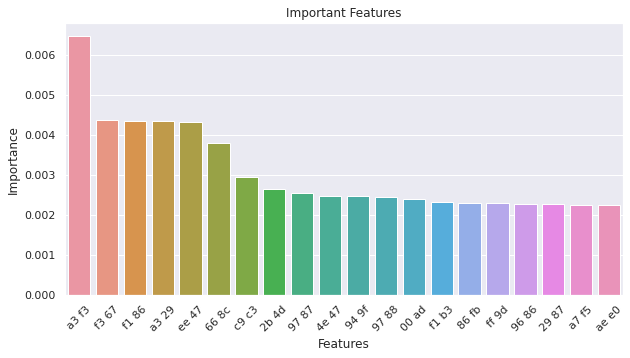

In [ ]:
byte_bi_indxes_main,imp = imp_features(big_values, bi_g, 300)

In [ ]:
np.save('byte_bigram_index_4fb', byte_bi_indxes_main)

In [ ]:
byte_bigram_indexes = np.load('byte_bigram_index_4fb.npy')

In [ ]:
top_bigram = np.zeros((10868, 0))
for i in byte_bigram_indexes:
  req = bigram_vect_final[:, i].todense()
  top_bigram = np.hstack([top_bigram, req])

In [ ]:
top_bigram.shape

(10868, 300)

In [ ]:
D = pd.DataFrame(top_bigram,columns = imp)

In [ ]:
D

a3 f3  f3 67  f1 86  a3 29  ee 47  ...  08 00  cb 00  5d c3  6d 2e  00 24
0       12.0   16.0   11.0   10.0   15.0  ...   29.0   19.0   85.0   19.0   17.0
1       17.0    8.0   12.0   14.0   13.0  ...   20.0   14.0   49.0   12.0   12.0
2       11.0   16.0    8.0   12.0   10.0  ...   15.0   12.0   64.0    9.0   17.0
3       28.0   22.0   32.0   26.0   24.0  ...   22.0   24.0   59.0   22.0   19.0
4        6.0    5.0   11.0   10.0    9.0  ...   92.0    9.0    4.0   16.0   18.0
...      ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
10863   15.0   21.0   11.0   17.0   15.0  ...   19.0    9.0   84.0    6.0   28.0
10864    0.0    0.0    0.0    0.0    0.0  ...  140.0    3.0  136.0    0.0  115.0
10865    6.0    2.0    3.0    4.0    6.0  ...    7.0    1.0    5.0    2.0    3.0
10866   12.0   11.0   12.0   13.0   16.0  ...   27.0   21.0   90.0    8.0   15.0
10867   34.0   18.0   12.0   28.0   28.0  ...   32.0   28.0   68.0   22.0   20.0

[10868 rows x 300 columns]

In [ ]:
D['Id'] = id1

In [ ]:
import pandas as pd
D.to_csv('new_features_updated_4fb.csv')

In [ ]:
import pandas as pd
Data = pd.read_csv('new_features_updated_4fb.csv')

In [ ]:
import pandas as pd
values = pd.read_csv('new_features_updated_4fb.csv').drop('Unnamed: 0', axis = 1)

In [ ]:
# from sklearn.preprocessing import normalize
# big_values_norm = normalize(big_values)

In [ ]:
# big_values_norm.shape

(10868, 300)

In [ ]:
# Data= pd.read_csv('trainLabels.csv')

In [ ]:
byte_size_feature = pd.read_csv('result_with_size.csv')

In [ ]:
byte_size_features_only = byte_size_feature.drop(['ID','Class','Unnamed: 0'], axis = 1)

In [ ]:
from sklearn.preprocessing import normalize
byte_size_features_only_norm = normalize(byte_size_features_only,axis = 0)

In [ ]:
df_byte_size_features = pd.DataFrame(byte_size_features_only_norm)

In [ ]:
df_byte_size_features['Id'] = byte_size_feature['ID']
df_byte_size_features['Class'] = byte_size_feature['Class']

In [ ]:
df_byte_size_features

0         1         2  ...       257                    Id  Class
0      0.050322  0.001813  0.000522  ...  0.008418  01azqd4InC7m9JpocGv5      9
1      0.003324  0.003870  0.001343  ...  0.011010  01IsoiSMh5gxyDYTl4CB      2
2      0.007818  0.004430  0.000476  ...  0.007728  01jsnpXSAlgw6aPeDxrU      9
3      0.001763  0.000563  0.000135  ...  0.001141  01kcPWA9K2BOxQeS5Rju      1
4      0.001652  0.000330  0.000056  ...  0.000737  01SuzwMJEIXsK7A8dQbl      8
...         ...       ...       ...  ...       ...                   ...    ...
10863  0.000440  0.000546  0.000199  ...  0.003733  loIP1tiwELF9YNZQjSUO      4
10864  0.000253  0.000138  0.000046  ...  0.000428  LOP6HaJKXpkic5dyuVnT      4
10865  0.000474  0.000103  0.000050  ...  0.000428  LOqA6FX02GWguYrI1Zbe      4
10866  0.000304  0.000203  0.000084  ...  0.001094  LoWgaidpb2IUM5ACcSGO      4
10867  0.000295  0.000173  0.000071  ...  0.000999  lS0IVqXeJrN6Dzi9Pap1      4

[10868 rows x 260 columns]

**Merging size featues with bigrams**

In [ ]:
all_features = values.merge(df_byte_size_features, how='left',on='Id')

In [ ]:
all_features.head()

a3 f3  f3 67  f1 86  a3 29  ...       255       256       257  Class
0   12.0   16.0   11.0   10.0  ...  0.002373  0.016331  0.013602      3
1   17.0    8.0   12.0   14.0  ...  0.002391  0.016336  0.013602      3
2   11.0   16.0    8.0   12.0  ...  0.002316  0.016331  0.013602      3
3   28.0   22.0   32.0   26.0  ...  0.003397  0.016662  0.018144      3
4    6.0    5.0   11.0   10.0  ...  0.001064  0.000173  0.003377      6

[5 rows x 560 columns]

In [ ]:
all_features.to_csv("final_byte.csv")

In [ ]:
Y = all_features['Class']
X = all_features.drop(columns = ['Id','Class'], axis = 1)

In [ ]:
X.head(2)

a3 f3  f3 67  f1 86  a3 29  ...       254       255       256       257
0   12.0   16.0   11.0   10.0  ...  0.005128  0.002373  0.016331  0.013602
1   17.0    8.0   12.0   14.0  ...  0.005121  0.002391  0.016336  0.013602

[2 rows x 558 columns]

In [ ]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(X, Y,stratify=Y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

In [ ]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 6955
Number of data points in test data: 2174
Number of data points in cross validation data: 1739


In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

Random model

Log loss on Cross Validation Data using Random Model 2.4742745395579893
Log loss on Test Data using Random Model 2.4584693271304014
Number of misclassified points  88.36246550137994
-------------------------------------------------- Confusion matrix --------------------------------------------------


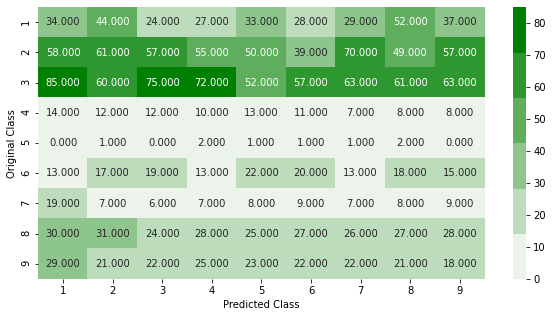

-------------------------------------------------- Precision matrix --------------------------------------------------


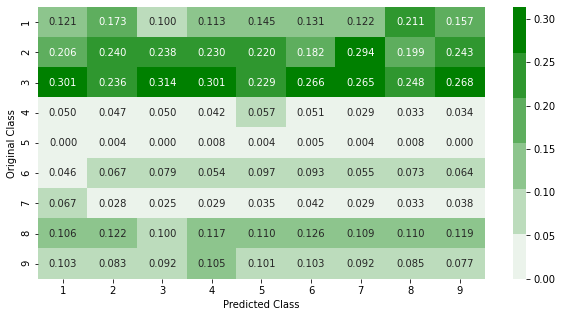

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


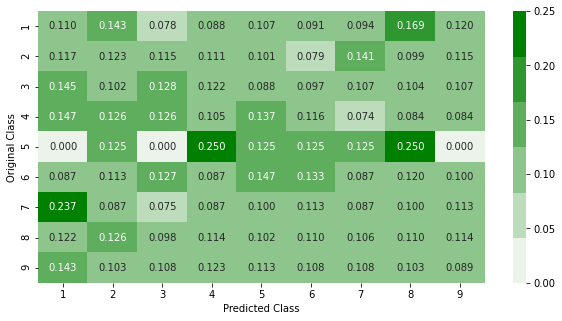

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

ramdom forest

log_loss for c =  10 is 0.10515246800254373
log_loss for c =  50 is 0.09255017872389339


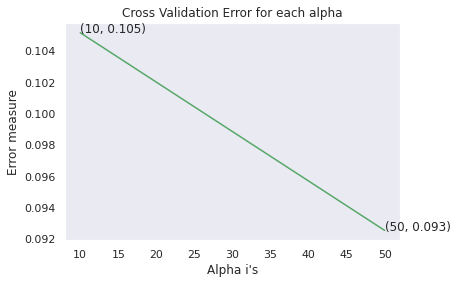

For values of best alpha =  50 The train log loss is: 0.02778460904555567
For values of best alpha =  50 The cross validation log loss is: 0.09255017872389339
For values of best alpha =  50 The test log loss is: 0.08642017178922626
Number of misclassified points  1.701931922723091
-------------------------------------------------- Confusion matrix --------------------------------------------------


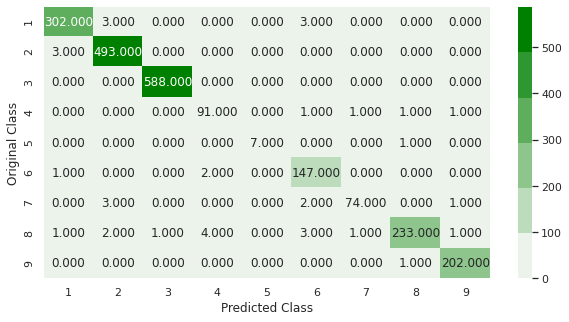

-------------------------------------------------- Precision matrix --------------------------------------------------


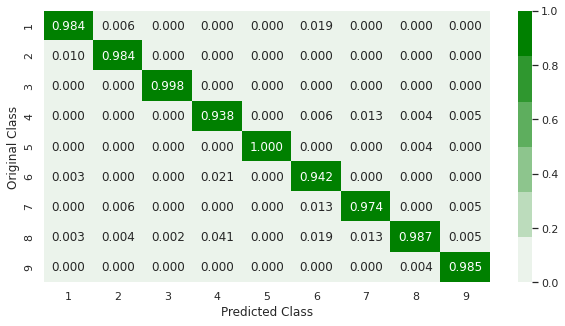

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


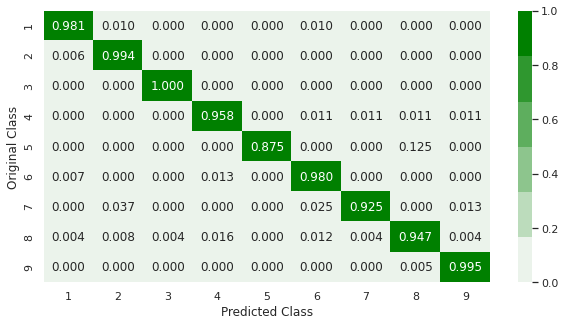

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

alpha=[10,50100,500,1000,2000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

log_loss for c =  10 is 0.20048080687678518
log_loss for c =  50 is 0.0922733118452911
log_loss for c =  100 is 0.06387551883725098
log_loss for c =  500 is 0.0626621054886031
log_loss for c =  1000 is 0.06323669647195984
log_loss for c =  2000 is 0.06310144114358548


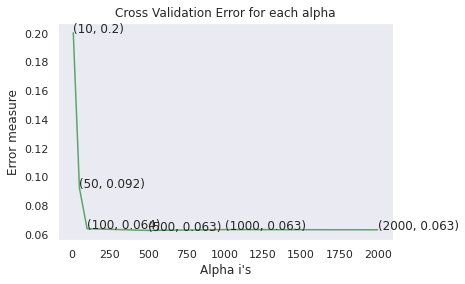

For values of best alpha =  500 The train log loss is: 0.02099563602550547
For values of best alpha =  500 The cross validation log loss is: 0.0626621054886031
For values of best alpha =  500 The test log loss is: 0.06564898230866083
Number of misclassified points  1.1959521619135236
-------------------------------------------------- Confusion matrix --------------------------------------------------


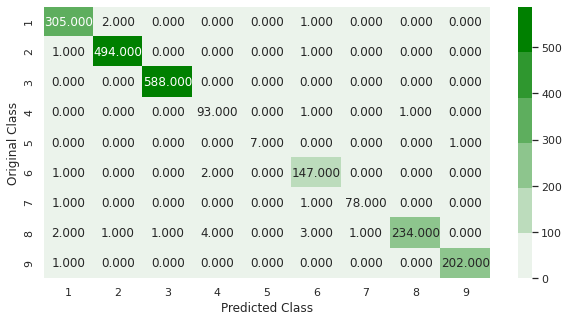

-------------------------------------------------- Precision matrix --------------------------------------------------


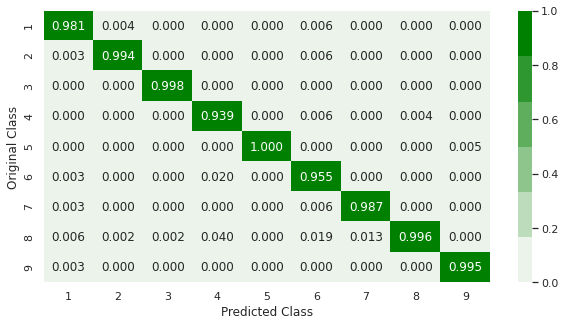

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


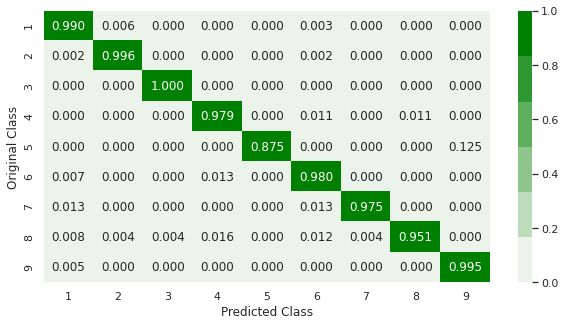

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

In [ ]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  50 | elapsed:  3.5min remaining: 21.5min
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:  3.9min remaining: 11.1min
[Parallel(n_jobs=-1)]: Done  19 out of  50 | elapsed:  4.4min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:  5.1min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:  5.8min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:  6.2min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:  6.4min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.6min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [ ]:
print (random_cfl.best_params_)

{'subsample': 0.3, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.15, 'colsample_bytree': 0.5}


In [ ]:

x_cfl=XGBClassifier(n_estimators=1000,subsample=0.3,learning_rate=0.15,colsample_bytree=0.5,max_depth=3)
x_cfl.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train,y_train)

predict_y = c_cfl.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv)
print ('cv loss',log_loss(y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))

train loss 0.021052061859438684
cv loss 0.07386287292892352
test loss 0.06937996925615564


|Model||Features||Hyperparameter||test loss|
|-----||----||---||-----|
|Random forest||Unigram,byte File size and bigram feature||best alpha = 50||0.08642017178922626|
|Xg-Boost regressor||Unigram,byte File size and bigram feature||best alpha = 500||0.06964898230866083|
|Xg-Boost regressor-with randomcv||Unigram,byte File size and bigram feature||best alpha = 1000||0.06937996925615564|

Image feature

In [ ]:
#Delete all the asm files
!rm -r -f asmfiles/

In [ ]:
#To download all the byte files from train.7z and below code will take almost 15mins.
from datetime import datetime
start=datetime.now()

!7z e train.7z -o/content/gdrive/MyDrive/asmfiles *.asm -r

end=datetime.now()
difference=end-start
print('Time taken to extract all the byte files',difference)


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,40 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 18810691091 bytes (18 GiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 18810691091
Headers Size = 339764
Method = LZMA:24
Solid = +
Blocks = 94

  0%      0% - train/01azqd4InC7m9JpocGv5.asm                                       0% 1 - train/01IsoiSMh5gxyDYTl4CB.asm                                         0% 2 - train/01jsnpXSAlgw6aPeDxrU.asm                                         0% 4 - train/01SuzwMJEIXsK7A8dQbl.asm

In [ ]:
files = os.listdir("/content/gdrive/MyDrive/asmfiles")

In [ ]:
len(files)

10868

In [ ]:
#!rm -r -f asmbatch/
!mkdir png_image

In [ ]:
import codecs
import imageio#https://stackoverflow.com/questions/41228209/making-gif-from-images-using-imageio-in-python
def collect_img_asm(asmfiles):
  pid = os.getpid()
  string_pid = str(pid)
  for i,asmfile in enumerate(asmfiles):
      filename = asmfile.split('.')[0]
      file = codecs.open("/content/gdrive/MyDrive/asmfiles/" + asmfile, 'rb')
      filelen = os.path.getsize("/content/gdrive/MyDrive/asmfiles/" + asmfile)
      width = int(filelen ** 0.5)
      rem = int(filelen / width)
      arr = array.array('B')
      arr.frombytes(file.read())
      print(pid,i+1,'files processed')
      file.close()
      reshaped = np.reshape(arr[:width * width], (width, width))
      reshaped = np.uint8(reshaped)
      imageio.imwrite('png_image/' + filename + '.png',reshaped)

In [ ]:
%%time
from multiprocessing import Pool
q = int(len(files)/22)
t1 = files[:q]
t2 = files[q:(2*q)]
t3 = files[(2*q):(3*q)]
t4 = files[(3*q):(4*q)]
t5 = files[(4*q):(5*q)]
t6 = files[(5*q):(6*q)]
t7 = files[(6*q):(7*q)]
t8 = files[(7*q):(8*q)]
t9 = files[(8*q):(9*q)]
t10 = files[(9*q):(10*q)]
t11 = files[(10*q):(11*q)]
t12 = files[(11*q):(12*q)]
t13 = files[(12*q):(13*q)]
t14 = files[(13*q):(14*q)]
t15 = files[(14*q):(15*q)]
t16 = files[(15*q):(16*q)]
t17 = files[(16*q):(17*q)]
t18 = files[(17*q):(18*q)]
t19 = files[(18*q):(19*q)]
t20 = files[(19*q):(20*q)]
t21 = files[(20*q):(21*q)]
t22 = files[(21*q):]
t = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22]
p = Pool(22)
p.map(collect_img_asm,t)#https://stackoverflow.com/questions/61341745/python-multiple-processing-using-pool

Streaming output truncated to the last 5000 lines.
1262 265 files processed
1261 275 files processed
1256 276 files processed
1255 303 files processed
1253 252 files processed
1254 281 files processed
1247 268 files processed
1252 277 files processed
1264 265 files processed
1259 250 files processed
1248 287 files processed
1260 264 files processed
1249 252 files processed
1262 266 files processed
1263 269 files processed
1244 297 files processed
1246 248 files processed
1258 257 files processed
1247 269 files processed
1252 278 files processed
1262 267 files processed
1254 282 files processed
1245 277 files processed
1250 260 files processed
1248 288 files processed
1264 266 files processed
1261 276 files processed
1256 277 files processed
1251 264 files processed
1259 251 files processed
1252 279 files processed
1260 265 files processed
1262 268 files processed
1247 270 files processed
1260 266 files processed
1259 252 files processed
1249 253 files processed
1252 280 files processed

In [ ]:
import cv2
imagefeatures = np.zeros((10868, 200))

In [ ]:
filename = []
for i, asmfile in enumerate(os.listdir("/content/gdrive/MyDrive/asmfiles")):
    img = cv2.imread("png_image/" + asmfile.split('.')[0] + '.png')
    filename.append(asmfile.split('.')[0])
    img_arr = img.flatten()[:200]
    imagefeatures[i, :] += img_arr

In [ ]:
len(imagefeatures[0])

200

In [ ]:
from sklearn.preprocessing import normalize
img_features_name = []
for i in range(200):
    img_features_name.append('pix' + str(i))
imgdf = pd.DataFrame(normalize(imagefeatures, axis = 0), columns = img_features_name)

In [ ]:
imgdf['ID'] = filename

In [ ]:
imgdf.head()

pix0      pix1      pix2  ...    pix198    pix199                    ID
0  0.010268  0.010268  0.010268  ...  0.009593  0.009593  01azqd4InC7m9JpocGv5
1  0.006560  0.006560  0.006560  ...  0.009593  0.009593  01IsoiSMh5gxyDYTl4CB
2  0.010268  0.010268  0.010268  ...  0.009593  0.009593  01jsnpXSAlgw6aPeDxrU
3  0.010268  0.010268  0.010268  ...  0.009593  0.009593  01kcPWA9K2BOxQeS5Rju
4  0.010268  0.010268  0.010268  ...  0.009593  0.009593  01SuzwMJEIXsK7A8dQbl

[5 rows x 201 columns]

In [ ]:
imgdf.to_csv('pixel_val_with_ID.csv')

In [ ]:
data = pd.read_csv('pixel_val_with_ID.csv')

In [ ]:
data= data.rename(columns={'ID': 'Id'})

In [ ]:
data.head(2)

Unnamed: 0      pix0      pix1  ...    pix198    pix199                    Id
0           0  0.010268  0.010268  ...  0.009593  0.009593  01azqd4InC7m9JpocGv5
1           1  0.006560  0.006560  ...  0.009593  0.009593  01IsoiSMh5gxyDYTl4CB

[2 rows x 202 columns]

In [ ]:
output = pd.read_csv('asmoutputfile.csv')

In [ ]:
output = output.rename(columns = {'ID':'Id'})

In [ ]:
labels = pd.read_csv('trainLabels.csv')

In [ ]:
labels.head(2)

Id  Class
0  01kcPWA9K2BOxQeS5Rju      1
1  04EjIdbPV5e1XroFOpiN      1

In [ ]:
dfinal1 = data.merge(output, how='left',on='Id')

In [ ]:
dfinal = dfinal1.merge(labels, how='left',on='Id')

In [ ]:
dfinal.head(5)

Unnamed: 0      pix0      pix1      pix2  ...  ebp  esp  eip  Class
0           0  0.010268  0.010268  0.010268  ...   15   14  456      9
1           1  0.006560  0.006560  0.006560  ...   24   22  227      2
2           2  0.010268  0.010268  0.010268  ...   27    0  117      9
3           3  0.010268  0.010268  0.010268  ...   17   48   29      1
4           4  0.010268  0.010268  0.010268  ...   15    0   76      8

[5 rows x 254 columns]

In [ ]:
dfinal.drop('Unnamed: 0', axis = 1,inplace = True)

In [ ]:
dfinal.to_csv('All_asm.csv')

In [ ]:
dfinal = pd.read_csv('All_asm.csv')

In [ ]:
dfinal.drop(['Id'],axis = 1,inplace = True)

In [ ]:
dfinal.drop('Unnamed: 0', axis = 1,inplace = True)

In [ ]:
dfinal.head()


pix0      pix1      pix2      pix3      pix4  ...  edi  ebp  esp  eip  Class
0  0.010268  0.010268  0.010268  0.008033  0.008033  ...    0   15   14  456      9
1  0.006560  0.006560  0.006560  0.013504  0.013504  ...    0   24   22  227      2
2  0.010268  0.010268  0.010268  0.008033  0.008033  ...    0   27    0  117      9
3  0.010268  0.010268  0.010268  0.008033  0.008033  ...    0   17   48   29      1
4  0.010268  0.010268  0.010268  0.008033  0.008033  ...    0   15    0   76      8

[5 rows x 252 columns]

In [ ]:
Y = dfinal['Class']
X = dfinal.drop('Class',axis = 1).values

In [ ]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(X, Y,stratify=Y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

In [ ]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 6955
Number of data points in test data: 2174
Number of data points in cross validation data: 1739


In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

Random forest on all asm features

log_loss for c =  10 is 0.049220155220710604
log_loss for c =  50 is 0.046382332350008854
log_loss for c =  100 is 0.04595496317934952
log_loss for c =  500 is 0.04533438000107591
log_loss for c =  1000 is 0.045200604658236665
log_loss for c =  2000 is 0.04491832142085445


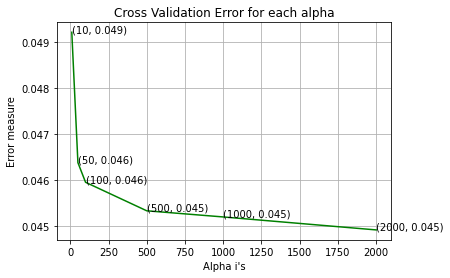

For values of best alpha =  2000 The train log loss is: 0.02114996790176527
For values of best alpha =  2000 The cross validation log loss is: 0.04491832142085445
For values of best alpha =  2000 The test log loss is: 0.03718196710658685
Number of misclassified points  0.8739650413983441
-------------------------------------------------- Confusion matrix --------------------------------------------------


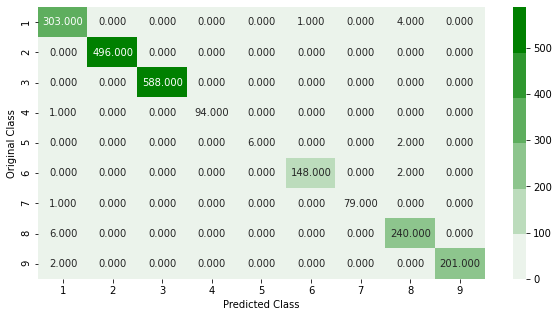

-------------------------------------------------- Precision matrix --------------------------------------------------


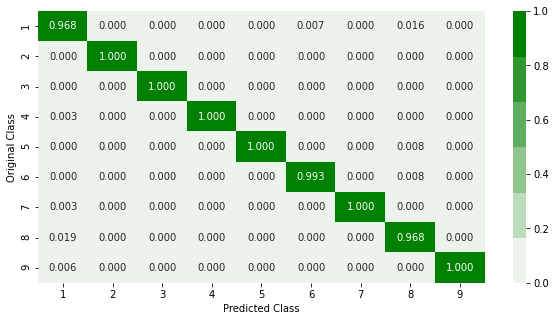

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


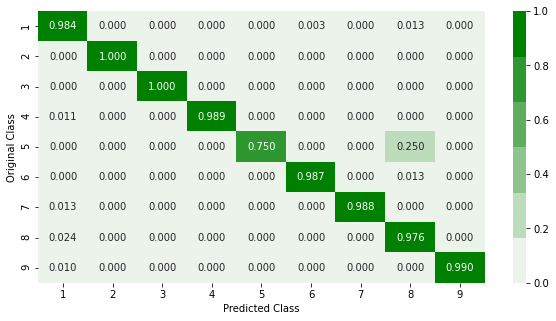

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

log_loss for c =  10 is 0.10697488128973562
log_loss for c =  50 is 0.05519651146542611
log_loss for c =  100 is 0.043615679043364115
log_loss for c =  500 is 0.043482426651698276
log_loss for c =  1000 is 0.04360755458252467
log_loss for c =  2000 is 0.04352304382848411


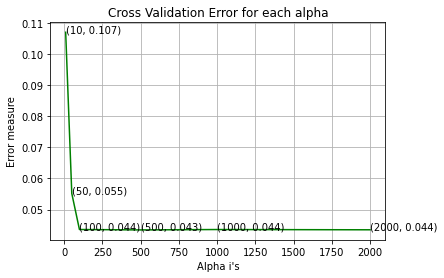

For values of best alpha =  500 The train log loss is: 0.018796025748493837
For values of best alpha =  500 The cross validation log loss is: 0.043482426651698276
For values of best alpha =  500 The test log loss is: 0.03612091627081045
Number of misclassified points  0.45998160073597055
-------------------------------------------------- Confusion matrix --------------------------------------------------


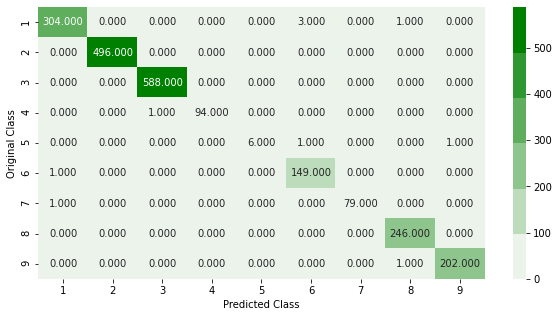

-------------------------------------------------- Precision matrix --------------------------------------------------


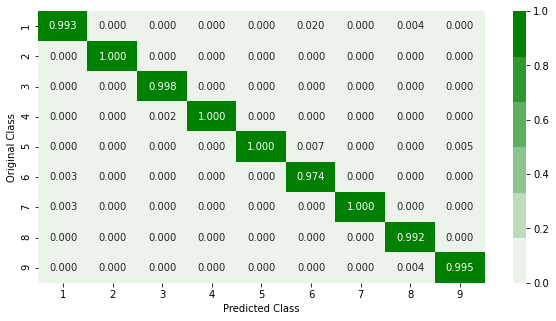

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


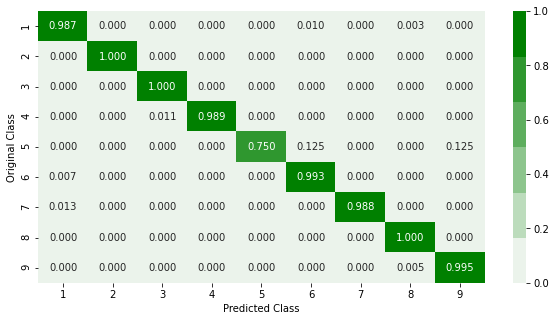

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

In [ ]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  50 | elapsed:   35.0s remaining:  3.6min
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:  1.2min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  19 out of  50 | elapsed:  1.8min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:  2.1min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:  2.3min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:  4.3min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:  4.6min remaining:   44.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.4min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [ ]:
print (random_cfl.best_params_)

{'subsample': 0.5, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.03, 'colsample_bytree': 0.5}


In [ ]:
x_cfl=XGBClassifier(n_estimators=2000,subsample=0.5,learning_rate=0.03,colsample_bytree=0.5,max_depth=10)
x_cfl.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train,y_train)

predict_y = c_cfl.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv)
print ('cv loss',log_loss(y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test)

train loss 0.01828363110434498
cv loss 0.044169099813979464


In [ ]:
predict_y = c_cfl.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))

test loss 0.031523435164007935


|Model||Features||Hyperparameter||test loss|
|-----||----||---||-----|
|Random forest||asm file features + asm file pixel intensity feature||best alpha = 2000||0.03718196710658685|
|Xg-Boost regressor||asm file features + asm file pixel intensity feature||best alpha = 500||0.03612091627081045|
|Xg-Boost regressor-with randomcv||asm file features + asm file pixel intensity feature||best alpha = 1000||0.031523435164007935|

combining Byte and ASM file features

In [ ]:
data1 = pd.read_csv('final_byte.csv')
data2= pd.read_csv('All_asm.csv')

In [ ]:
data1.drop('Class', axis = 1,inplace = True)

In [ ]:
data1.drop('Unnamed: 0', axis = 1,inplace = True)
data2.drop('Unnamed: 0', axis = 1,inplace = True)

In [ ]:
final_data = data1.merge(data2, how='left',on='Id')

In [ ]:
final_data.drop('Id', axis = 1,inplace = True)


In [ ]:
Y = final_data['Class']
X = final_data.drop('Class',axis = 1).values

In [ ]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(X, Y,stratify=Y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

In [ ]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 6955
Number of data points in test data: 2174
Number of data points in cross validation data: 1739


In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

Random forest on byte features and asm features

log_loss for c =  10 is 0.05776194548133131
log_loss for c =  50 is 0.052351248773401006
log_loss for c =  100 is 0.0520613983833348
log_loss for c =  500 is 0.051175149777791716
log_loss for c =  1000 is 0.05065694656826783
log_loss for c =  2000 is 0.05070014569170892


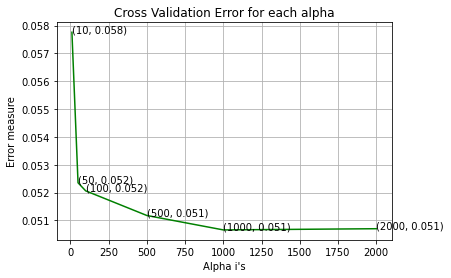

For values of best alpha =  1000 The train log loss is: 0.016636126601311276
For values of best alpha =  1000 The cross validation log loss is: 0.05065694656826783
For values of best alpha =  1000 The test log loss is: 0.038790144476366396
Number of misclassified points  0.7359705611775529
-------------------------------------------------- Confusion matrix --------------------------------------------------


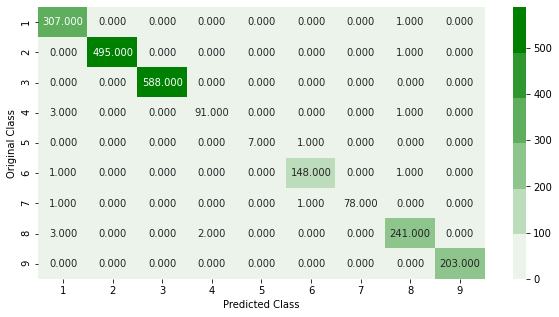

-------------------------------------------------- Precision matrix --------------------------------------------------


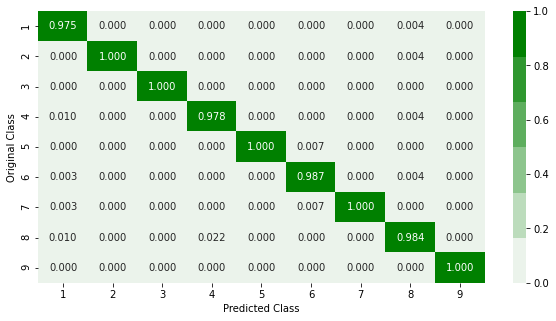

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


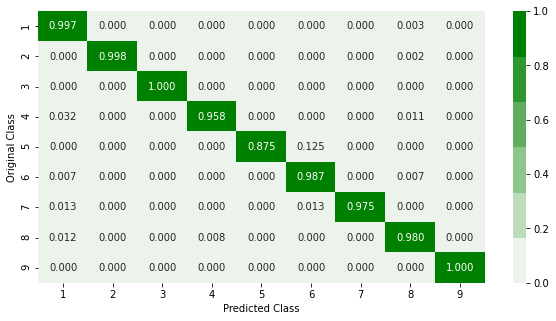

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

100%|██████████| 6/6 [10:42<00:00, 107.14s/it]

log_loss for c =  10 is 0.07922663084777584
log_loss for c =  50 is 0.04330424834856591
log_loss for c =  100 is 0.039962295669525805
log_loss for c =  500 is 0.04034633227921325
log_loss for c =  1000 is 0.041199321679282516
log_loss for c =  2000 is 0.04119631930018984


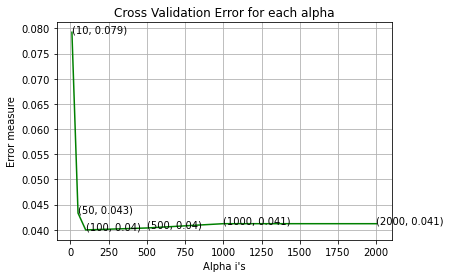

For values of best alpha =  100 The train log loss is: 0.013256519119306942
For values of best alpha =  100 The cross validation log loss is: 0.039962295669525805
For values of best alpha =  100 The test log loss is: 0.031103480108098096
Number of misclassified points  0.45998160073597055
-------------------------------------------------- Confusion matrix --------------------------------------------------


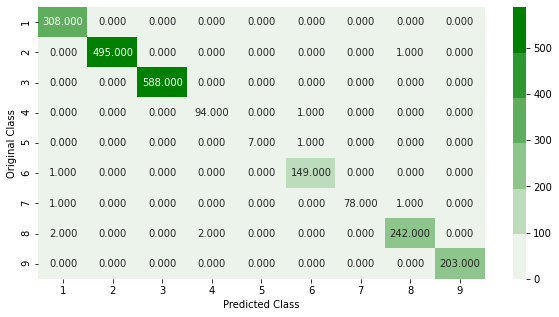

-------------------------------------------------- Precision matrix --------------------------------------------------


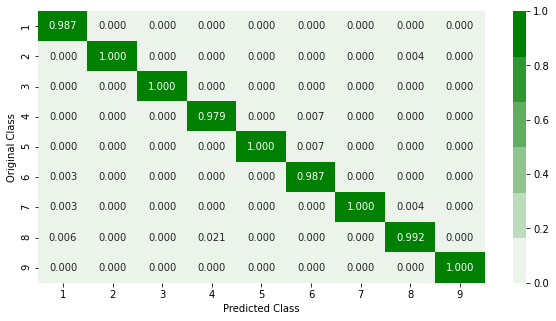

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


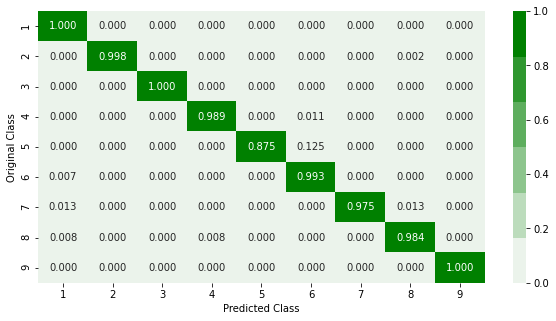

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------
from tqdm import tqdm
alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]
for i in tqdm(alpha):
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))



  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:56<02:48, 56.11s/it]

 50%|█████     | 2/4 [05:26<04:00, 120.36s/it]

 75%|███████▌  | 3/4 [14:18<04:04, 244.01s/it]

100%|██████████| 4/4 [26:40<00:00, 400.10s/it]

log_loss for c =  10 is 0.06803532758932102
log_loss for c =  50 is 0.04570071068283817
log_loss for c =  100 is 0.03844073513527102
log_loss for c =  200 is 0.03882260203148185


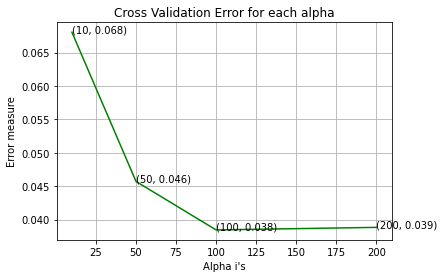

For values of best alpha =  100 The train log loss is: 0.013256519119306942
For values of best alpha =  100 The cross validation log loss is: 0.039962295669525805
For values of best alpha =  100 The test log loss is: 0.031103480108098096
Number of misclassified points  0.45998160073597055
-------------------------------------------------- Confusion matrix --------------------------------------------------


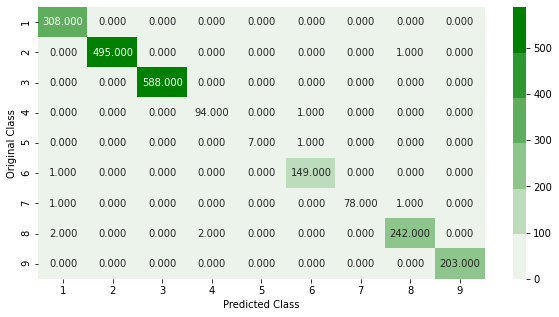

-------------------------------------------------- Precision matrix --------------------------------------------------


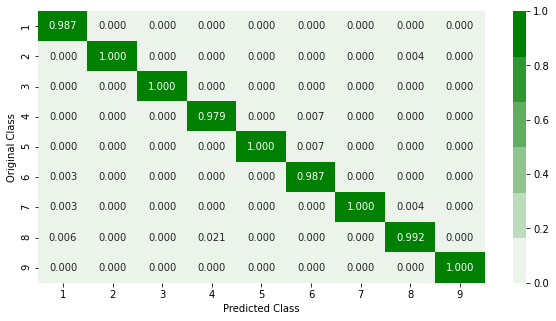

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


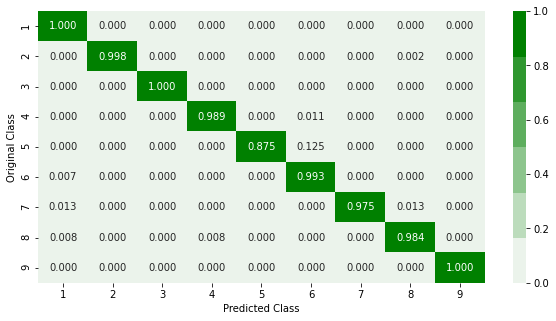

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------
from tqdm import tqdm
import lightgbm
alpha=[10,50,100,200]
cv_log_error_array=[]
for i in tqdm(alpha):
    x_cfl=lightgbm.LGBMClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

In [ ]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  50 | elapsed:  3.7min remaining: 22.7min
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:  4.6min remaining: 13.0min
[Parallel(n_jobs=-1)]: Done  19 out of  50 | elapsed:  5.0min remaining:  8.2min
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:  5.7min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:  8.5min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:  9.1min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed: 13.8min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 20.4min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [ ]:
print (random_cfl.best_params_)

{'subsample': 0.5, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.3}


In [ ]:
x_cfl=XGBClassifier(n_estimators=200,subsample=0.5,learning_rate=0.2,colsample_bytree=0.3,max_depth=3)
x_cfl.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train,y_train)

predict_y = c_cfl.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv)
print ('cv loss',log_loss(y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test)

train loss 0.013083767012208796
cv loss 0.04334955447106449


In [ ]:
predict_y = c_cfl.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))

test loss 0.02993039632795083


|Model||Features||Hyperparameter||test loss|
|-----||----||---||-----|
|Random forest||all Byte features+ all asm features with pixel intensity||best alpha = 2000||0.038790144476366396|
|Xg-Boost regressor||all Byte features+ all asm features with pixel intensity||best alpha = 000||0.031103480108098096|
|Xg-Boost regressor-with randomcv||all Byte features+ all asm features with pixel intensity||best alpha = 200||0.02993039632795083|

**calculating Opcode feature**

In [5]:
 opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul'
 , 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']

In [ ]:
 #refered from https://github.com/saicharanarishanapally/microsoft-malware-detection
asmopcodebigram_key = []
def asmopcodebigram():

  for i, v in enumerate(opcodes):
    for j in range(0, len(opcodes)):
      asmopcodebigram_key.append(v + ' ' + opcodes[j])
  print(len(asmopcodebigram_key))
asmopcodebigram()

676


In [ ]:
asmopcodetrigram_key = [] #refered from https://github.com/saicharanarishanapally/microsoft-malware-detection
def asmopcodetrigram():

 for i, v in enumerate(opcodes):
  for j in range(0, len(opcodes)):
    for k in range(0, len(opcodes)):
      asmopcodetrigram_key.append(v + ' ' + opcodes[j] + ' ' + opcodes[k])
 print(len(asmopcodetrigram_key))

asmopcodetrigram()

17576


In [ ]:
!rm opcode_file.txt

rm: cannot remove 'opcode_file.txt': No such file or directory


In [ ]:
# from tqdm import tqdm
# def opcode_collect():
#   #pid = os.getpid()
#   #print('Process started with id = ', pid)
#   op_file = open("opcode_file.txt", "w+")
#   files = os.listdir('/content/gdrive/MyDrive/asmfiles')
#   for asmfile in tqdm(files):
#     opcode_str = ""
#     with codecs.open('/content/gdrive/MyDrive/asmfiles/' + asmfile, encoding='cp1252', errors ='replace') as fli:
#       for lines in fli:
#         line = lines.rstrip().split()
#         for li in line:
#           if li in opcodes:
#             opcode_str += li + ' '
#     op_file.write(opcode_str + "\n")
#     #print(pid,i+1,'files processed')
#   op_file.close()
# opcode_collect()  

In [6]:
from tqdm import tqdm
def opcode_collect(files):
  pid = os.getpid()
  print('Process started with id = ', pid)
  str_pid = str(pid)
  op_file = open("opcode_"+str_pid+"_file.txt", "w+")
  id = []
  #files = os.listdir(files)
  for i,asmfile in enumerate(files):
    opcode_str = ""
    id.append(asmfile.split('.')[0])
    with codecs.open('/content/gdrive/MyDrive/asmfiles/' + asmfile, encoding='cp1252', errors ='replace') as fli:
      for lines in fli:
        line = lines.rstrip().split()
        for li in line:
          if li in opcodes:
            opcode_str += li + ' '
    op_file.write(opcode_str + "\n")
    print(pid,i+1,'files processed')
  op_file.close()
  return id
#opcode_collect() 

In [7]:
%%time
import os
from multiprocessing import Pool
files = os.listdir('/content/gdrive/MyDrive/asmfiles')
q = int(len(files)/22)
t1 = files[:q]
t2 = files[q:(2*q)]
t3 = files[(2*q):(3*q)]
t4 = files[(3*q):(4*q)]
t5 = files[(4*q):(5*q)]
t6 = files[(5*q):(6*q)]
t7 = files[(6*q):(7*q)]
t8 = files[(7*q):(8*q)]
t9 = files[(8*q):(9*q)]
t10 = files[(9*q):(10*q)]
t11 = files[(10*q):(11*q)]
t12 = files[(11*q):(12*q)]
t13 = files[(12*q):(13*q)]
t14 = files[(13*q):(14*q)]
t15 = files[(14*q):(15*q)]
t16 = files[(15*q):(16*q)]
t17 = files[(16*q):(17*q)]
t18 = files[(17*q):(18*q)]
t19 = files[(18*q):(19*q)]
t20 = files[(19*q):(20*q)]
t21 = files[(20*q):(21*q)]
t22 = files[(21*q):]
t = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22]
p = Pool(22)
id1,id2,id3,id4,id5,id6,id7,id8,id9,id10,id11,id12,id13,id14,id15,id16,id17,id18,id19,id20,id21,id22  = p.map(opcode_collect,t)#https://stackoverflow.com/questions/61341745/python-multiple-processing-using-pool

Streaming output truncated to the last 5000 lines.
777 246 files processed
776 270 files processed
766 255 files processed
781 298 files processed
777 247 files processed
776 271 files processed
761 267 files processed
761 268 files processed
780 267 files processed
764 236 files processed
779 261 files processed
760 283 files processed
764 237 files processed
761 269 files processed
779 262 files processed
766 256 files processed
780 268 files processed
764 238 files processed
778 289 files processed
780 269 files processed
778 290 files processed
781 299 files processed
780 270 files processed
766 257 files processed
771 256 files processed
768 271 files processed
779 263 files processed
774 298 files processed
767 260 files processed
764 239 files processed
779 264 files processed
780 271 files processed
781 300 files processed
767 261 files processed
779 265 files processed
767 262 files processed
764 240 files processed
769 238 files processed
774 299 files processed
781 301 files

In [ ]:
# data1 = data2 = data3 = data4 = data5 = data6 = data7 = data8 = data9 = data10 =  data11 = data12 =  ""
# data13 = data14 = data15 = data16 =  data17 = data18 =  data19 = data20 = data21 = data22 = ""
# with open('opcode_3442_file.txt') as fp: 
#     data = fp.read() 
# with open('opcode_3443_file.txt') as fp: 
#     data = fp.read()
# with open('opcode_3444_file.txt') as fp: 
#     data = fp.read()
# with open('opcode_3442_file.txt') as fp: 
#     data = fp.read()
# with open('opcode_3442_file.txt') as fp: 
#     data = fp.read()
# with open('opcode_3442_file.txt') as fp: 
#     data = fp.read()

for i in range(615,637):#combining all txt files
  str_i = str(i)
  data = ""
  with open('opcode_'+str_i+'_file.txt') as (globals()['fp'+str(i)]): 
    data = (globals()['fp'+str(i)]).read()
  if i == 615: 
    fp2 = open('fileallopcode2.txt', 'w') 
  fp2.write(data) 
  #fp.close()
fp2.close()

In [ ]:
id1.extend(id2) #combining all ids
id1.extend(id3)
id1.extend(id4)
id1.extend(id5)
id1.extend(id6)
id1.extend(id7)
id1.extend(id8)
id1.extend(id9)
id1.extend(id10)
id1.extend(id11)
id1.extend(id12)
id1.extend(id13)
id1.extend(id14)
id1.extend(id15)
id1.extend(id16)
id1.extend(id17)
id1.extend(id18)
id1.extend(id19)
id1.extend(id20)
id1.extend(id21)
id1.extend(id22)

In [ ]:
len(id1)

10868

In [ ]:
vect = CountVectorizer(ngram_range=(2, 2), vocabulary = asmopcodebigram_key)  #regered from https://github.com/saicharanarishanapally/microsoft-malware-detection
opcodebivect = scipy.sparse.csr_matrix((10868, len(asmopcodebigram_key)))
raw_opcode = open('fileallopcode2.txt').read().split('\n')
raw_opcode = raw_opcode[:-1]#removing last blank list
for indx in tqdm(range(10868), position=0, leave=True):
 opcodebivect[indx, :] += scipy.sparse.csr_matrix(vect.transform([raw_opcode[indx]]))
opcodebivect

  0%|          | 0/10868 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
100%|██████████| 10868/10868 [04:29<00:00, 40.27it/s]


<10868x676 sparse matrix of type '<class 'numpy.float64'>'
	with 1877309 stored elements in Compressed Sparse Row format>

In [ ]:
len(raw_opcode)

10868

In [ ]:
scipy.sparse.save_npz('opbigram.npz', opcodebivect)

In [ ]:
vect = CountVectorizer(ngram_range=(3, 3), vocabulary = asmopcodetrigram_key) #regered from https://github.com/saicharanarishanapally/microsoft-malware-detection
opcodetrivect = scipy.sparse.csr_matrix((10868, len(asmopcodetrigram_key)))
for indx in tqdm(range(10868), position=0, leave=True):
  opcodetrivect[indx, :] += scipy.sparse.csr_matrix(vect.transform([raw_opcode[indx]]))

  0%|          | 0/10868 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
100%|██████████| 10868/10868 [14:25<00:00, 12.56it/s]


In [ ]:
scipy.sparse.save_npz('optrivect.npz', opcodetrivect)


In [ ]:
# Loading all opcode bigram and trigram
optrivect=scipy.sparse.load_npz('optrivect.npz')
opbivect=scipy.sparse.load_npz('opbigram.npz')

In [ ]:
#feature bi gram  #refered from https://github.com/saicharanarishanapally/microsoft-malware-detection
from sklearn.preprocessing import normalize
opcodebivect_bigram = normalize(opbivect, axis = 0)
feature_matrix_bi_sparse = pd.DataFrame(opcodebivect_bigram.toarray())
feature_matrix_bi_sparse.columns = asmopcodebigram_key
feature_matrix_bi_sparse.head()

jmp jmp   jmp mov  jmp retf  ...  movzx rtn  movzx lea  movzx movzx
0  0.001012  0.004259       0.0  ...        0.0   0.000000     0.000156
1  0.000000  0.000162       0.0  ...        0.0   0.000000     0.000156
2  0.000000  0.000690       0.0  ...        0.0   0.000000     0.000000
3  0.000289  0.002069       0.0  ...        0.0   0.001671     0.000779
4  0.000000  0.000000       0.0  ...        0.0   0.000000     0.000000

[5 rows x 676 columns]

In [ ]:
c = pd.DataFrame(id1)

In [ ]:
c.columns = ['Id']

In [ ]:
c

Id
0      h1A0cfYFC7vrnDRxNXHa
1      er3fFEimPIGXOdHL4tx1
2      3iHvsmdx7DauhSPKfec4
3      a9r2zHUoK5gXj8E0lqsb
4      2xmv5zSqBlakorbUw9MJ
...                     ...
10863  2vN1Rihuanrg6UZoQqxV
10864  BF6U3mKD1Tvgz2toNr84
10865  9WTo14gKIRY058DCadmS
10866  JXyRIzCVsMceZBp5aWOk
10867  k6Mnj2POrsKEqVxeNJAu

[10868 rows x 1 columns]

In [ ]:
data = pd.read_csv('trainLabels.csv')

In [ ]:
final = c.merge(data, how='left',on='Id')

In [ ]:
data.head()

Id  Class
0  01kcPWA9K2BOxQeS5Rju      1
1  04EjIdbPV5e1XroFOpiN      1
2  05EeG39MTRrI6VY21DPd      1
3  05rJTUWYAKNegBk2wE8X      1
4  0AnoOZDNbPXIr2MRBSCJ      1

In [ ]:
bigram_without_id = feature_matrix_bi_sparse.drop('ID',axis = 1)

In [ ]:
type(bigram_without_id)

In [ ]:
data_y = data['Class']  #refered from https://github.com/saicharanarishanapally/microsoft-malware-detection
clf = RandomForestClassifier(n_jobs = -1)
clf.fit(feature_matrix_bi_sparse,data_y)
imp_bigrams = clf.feature_importances_
print(f'Important Biagram : {imp_bigrams}')
idx_bigram = np.argsort(imp_bigrams)[::-1]
print(idx_bigram)
print(imp_bigrams[idx_bigram[:200]])
print(feature_matrix_bi_sparse.columns[idx_bigram[200:]])

Important Biagram : [3.32372108e-03 5.24477966e-03 5.35638537e-04 4.79746556e-03
 2.16064592e-03 1.79739211e-03 1.29571094e-03 2.47609342e-04
 1.48675879e-03 1.24413940e-03 1.10967195e-03 1.83209377e-03
 5.81914454e-04 7.03093681e-04 1.29246821e-03 3.94892264e-04
 1.73754162e-03 2.20083023e-03 4.26376848e-04 1.42168198e-04
 1.09330497e-04 1.36997399e-04 6.34200675e-04 0.00000000e+00
 1.75068251e-03 5.38082638e-04 3.31130034e-03 1.54956186e-02
 7.47743066e-04 1.21478448e-02 4.99513943e-03 8.84010573e-03
 3.19668039e-03 1.72818037e-03 8.63222416e-03 2.92648768e-03
 2.91737748e-03 8.42593993e-03 6.28553620e-03 1.68972087e-03
 7.22630451e-03 2.11085465e-03 7.51691968e-03 5.93481949e-03
 2.39153057e-03 1.04534382e-03 1.13622686e-03 6.80634761e-04
 3.15029046e-03 0.00000000e+00 7.05839175e-03 2.07096050e-03
 4.55563201e-04 8.72926683e-04 5.49599155e-04 1.30559745e-03
 4.39026312e-04 3.88572855e-04 5.35120391e-04 4.42090577e-05
 3.51299602e-04 3.88400895e-04 4.28074215e-04 4.62493286e-04
 1.3

In [ ]:
new = pd.read_csv('opcode_features_bi_tri.csv')
opcodeid = new['ID']

In [ ]:
feature_matrix_bi_sparse.drop(feature_matrix_bi_sparse.columns[idx_bigram[200:]],axis =1,inplace=True)
feature_matrix_bi_sparse["ID"] = opcodeid
feature_matrix_bi_sparse.shape
feature_matrix_bi_sparse.head(10)

jmp jmp   jmp mov  jmp push  ...  movzx mov  movzx sub                    ID
0  0.001012  0.004259  0.005674  ...   0.000220   0.001177  h1A0cfYFC7vrnDRxNXHa
1  0.000000  0.000162  0.000280  ...   0.000110   0.000000  er3fFEimPIGXOdHL4tx1
2  0.000000  0.000690  0.000560  ...   0.000331   0.000471  3iHvsmdx7DauhSPKfec4
3  0.000289  0.002069  0.000630  ...   0.001874   0.000942  a9r2zHUoK5gXj8E0lqsb
4  0.000000  0.000000  0.000070  ...   0.000000   0.000000  2xmv5zSqBlakorbUw9MJ
5  0.000000  0.002109  0.000911  ...   0.000000   0.000000  AygMUQ9GnsVrSlHtO1IJ
6  0.000362  0.001116  0.000210  ...   0.000110   0.000471  ecVFna7rh4PBNKHoMugD
7  0.000000  0.000000  0.000070  ...   0.000000   0.000000  iMfxGbk126VRgczUIp03
8  0.000000  0.001217  0.000350  ...   0.004741   0.004003  f3J7wQUqnge80iyXuxsL
9  0.000000  0.000000  0.000000  ...   0.000000   0.005887  cYQ7s8Kei2VALkgHlJGb

[10 rows x 201 columns]

In [ ]:
#feature tri gram  #refered from https://github.com/saicharanarishanapally/microsoft-malware-detection
from sklearn.preprocessing import normalize
opcodetrivect_tri = normalize(optrivect, axis = 0)
feature_matrix_trii_sparse = pd.DataFrame(opcodetrivect_tri.toarray())
feature_matrix_trii_sparse.columns = asmopcodetrigram_key
feature_matrix_trii_sparse.head()

jmp jmp jmp  jmp jmp mov  ...  movzx movzx lea  movzx movzx movzx
0     0.000819      0.00045  ...              0.0                0.0
1     0.000000      0.00000  ...              0.0                0.0
2     0.000000      0.00000  ...              0.0                0.0
3     0.000164      0.00090  ...              0.0                0.0
4     0.000000      0.00000  ...              0.0                0.0

[5 rows x 17576 columns]

In [ ]:
data_y = data['Class']   #refered from https://github.com/saicharanarishanapally/microsoft-malware-detection
clf = RandomForestClassifier(n_jobs = -1)
clf.fit(feature_matrix_trii_sparse,data_y)
imp_bigrams = clf.feature_importances_
print(f'Important Biagram : {imp_bigrams}')
idx_bigram = np.argsort(imp_bigrams)[::-1]
print(idx_bigram)
print(imp_bigrams[idx_bigram[:300]])
print(feature_matrix_trii_sparse.columns[idx_bigram[300:]])

Important Biagram : [1.01696141e-03 3.49792748e-04 9.28700521e-05 ... 0.00000000e+00
 4.81390399e-05 6.69087252e-05]
[ 2109   703  2057 ... 15632 15633  8787]
[0.0052679  0.00497498 0.00386472 0.00372872 0.00364443 0.00355955
 0.0034911  0.00319153 0.00315227 0.00307715 0.00305285 0.00302741
 0.00302234 0.00301849 0.00297524 0.00290741 0.00284227 0.00276442
 0.00276253 0.0027245  0.00271436 0.00270497 0.00270165 0.00269323
 0.00266088 0.00264379 0.00260937 0.00259775 0.00258835 0.00258538
 0.00257881 0.00253619 0.00250591 0.00244983 0.00240614 0.00240095
 0.00238937 0.00238702 0.00237667 0.00237654 0.0023146  0.00230796
 0.00227959 0.0022613  0.00223742 0.00221944 0.00221622 0.00217478
 0.00214817 0.00214462 0.00214419 0.0021333  0.00212323 0.00208371
 0.00208267 0.0020748  0.00205441 0.00205255 0.00202945 0.00199556
 0.00199432 0.0019927  0.00198128 0.00196803 0.00195562 0.00194906
 0.00193364 0.00191928 0.00191799 0.00189305 0.00188771 0.00187678
 0.00187042 0.00186934 0.00186478 0.0

In [ ]:
feature_matrix_trii_sparse.drop(feature_matrix_trii_sparse.columns[idx_bigram[300:]],axis =1,inplace=True)
feature_matrix_trii_sparse["ID"] = opcodeid
feature_matrix_trii_sparse.shape
feature_matrix_trii_sparse.head(10)

jmp jmp jmp  jmp mov mov  ...  lea lea push                    ID
0     0.000819     0.003841  ...      0.002251  h1A0cfYFC7vrnDRxNXHa
1     0.000000     0.000200  ...      0.000375  er3fFEimPIGXOdHL4tx1
2     0.000000     0.000249  ...      0.000375  3iHvsmdx7DauhSPKfec4
3     0.000164     0.001297  ...      0.002251  a9r2zHUoK5gXj8E0lqsb
4     0.000000     0.000000  ...      0.000000  2xmv5zSqBlakorbUw9MJ
5     0.000000     0.001846  ...      0.001501  AygMUQ9GnsVrSlHtO1IJ
6     0.000164     0.000848  ...      0.000000  ecVFna7rh4PBNKHoMugD
7     0.000000     0.000000  ...      0.000000  iMfxGbk126VRgczUIp03
8     0.000000     0.000948  ...      0.001501  f3J7wQUqnge80iyXuxsL
9     0.000000     0.000000  ...      0.001125  cYQ7s8Kei2VALkgHlJGb

[10 rows x 301 columns]

In [ ]:
opcode_features_bi_tri = pd.merge(feature_matrix_bi_sparse, feature_matrix_trii_sparse, on='ID', how=
'left')
opcode_features_bi_tri.head()

jmp jmp   jmp mov  jmp push  ...  lea cmp jz  lea call push  lea lea push
0  0.001012  0.004259  0.005674  ...    0.000913        0.00000      0.002251
1  0.000000  0.000162  0.000280  ...    0.000000        0.00000      0.000375
2  0.000000  0.000690  0.000560  ...    0.000000        0.00036      0.000375
3  0.000289  0.002069  0.000630  ...    0.000913        0.00054      0.002251
4  0.000000  0.000000  0.000070  ...    0.000913        0.00000      0.000000

[5 rows x 501 columns]

In [ ]:
opcode_features_bi_tri.to_csv('opcode_features_bi_tri.csv')  

In [ ]:
opcode_features_bi_tri = pd.read_csv('opcode_features_bi_tri.csv')

In [ ]:
opcode_features_bi_tri.rename(columns = {'ID':'Id'},inplace = True)

In [ ]:
opcode_features_bi_tri.columns.values

array(['Unnamed: 0', 'jmp jmp', 'jmp mov', 'jmp retf', 'jmp push',
       'jmp pop', 'jmp dec', 'jmp add', 'jmp or', 'jmp cmp', 'jmp call',
       'jmp jz', 'jmp lea', 'jmp movzx', 'mov jmp', 'mov mov', 'mov push',
       'mov pop', 'mov xor', 'mov retn', 'mov sub', 'mov inc', 'mov add',
       'mov imul', 'mov or', 'mov shr', 'mov cmp', 'mov call', 'mov shl',
       'mov jz', 'mov lea', 'mov movzx', 'retf jmp', 'retf retf',
       'push jmp', 'push mov', 'push push', 'push pop', 'push xor',
       'push sub', 'push inc', 'push dec', 'push add', 'push or',
       'push cmp', 'push call', 'push shl', 'push lea', 'pop mov',
       'pop push', 'pop pop', 'pop xor', 'pop retn', 'pop sub', 'pop add',
       'pop or', 'pop call', 'pop jz', 'pop lea', 'xor jmp', 'xor mov',
       'xor push', 'xor pop', 'xor retn', 'xor inc', 'xor xchg',
       'xor cmp', 'retn jmp', 'retn mov', 'retn push', 'retn xor',
       'retn retn', 'retn sub', 'retn add', 'retn cmp', 'sub jmp',
       'sub mov', 'sub p

In [ ]:
all_asm = pd.read_csv('All_asm.csv')
All_bytes = pd.read_csv('final_byte.csv')

In [ ]:
All_bytes

Unnamed: 0  a3 f3  f3 67  f1 86  ...       255       256       257  Class
0               0   12.0   16.0   11.0  ...  0.002373  0.016331  0.013602      3
1               1   17.0    8.0   12.0  ...  0.002391  0.016336  0.013602      3
2               2   11.0   16.0    8.0  ...  0.002316  0.016331  0.013602      3
3               3   28.0   22.0   32.0  ...  0.003397  0.016662  0.018144      3
4               4    6.0    5.0   11.0  ...  0.001064  0.000173  0.003377      6
...           ...    ...    ...    ...  ...       ...       ...       ...    ...
10863       10863   15.0   21.0   11.0  ...  0.002465  0.016359  0.013626      3
10864       10864    0.0    0.0    0.0  ...  0.022627  0.000071  0.011438      2
10865       10865    6.0    2.0    3.0  ...  0.000423  0.003836  0.003733      4
10866       10866   12.0   11.0   12.0  ...  0.002430  0.016348  0.013626      3
10867       10867   34.0   18.0   12.0  ...  0.003295  0.016628  0.018144      3

[10868 rows x 561 columns]

In [ ]:
All_bytes.drop('Class', axis = 1,inplace = True)

In [ ]:
All_bytes.drop('Unnamed: 0', axis = 1,inplace = True)
all_asm.drop('Unnamed: 0', axis = 1,inplace = True)

In [ ]:
all_asm.columns.values

array(['pix0', 'pix1', 'pix2', 'pix3', 'pix4', 'pix5', 'pix6', 'pix7',
       'pix8', 'pix9', 'pix10', 'pix11', 'pix12', 'pix13', 'pix14',
       'pix15', 'pix16', 'pix17', 'pix18', 'pix19', 'pix20', 'pix21',
       'pix22', 'pix23', 'pix24', 'pix25', 'pix26', 'pix27', 'pix28',
       'pix29', 'pix30', 'pix31', 'pix32', 'pix33', 'pix34', 'pix35',
       'pix36', 'pix37', 'pix38', 'pix39', 'pix40', 'pix41', 'pix42',
       'pix43', 'pix44', 'pix45', 'pix46', 'pix47', 'pix48', 'pix49',
       'pix50', 'pix51', 'pix52', 'pix53', 'pix54', 'pix55', 'pix56',
       'pix57', 'pix58', 'pix59', 'pix60', 'pix61', 'pix62', 'pix63',
       'pix64', 'pix65', 'pix66', 'pix67', 'pix68', 'pix69', 'pix70',
       'pix71', 'pix72', 'pix73', 'pix74', 'pix75', 'pix76', 'pix77',
       'pix78', 'pix79', 'pix80', 'pix81', 'pix82', 'pix83', 'pix84',
       'pix85', 'pix86', 'pix87', 'pix88', 'pix89', 'pix90', 'pix91',
       'pix92', 'pix93', 'pix94', 'pix95', 'pix96', 'pix97', 'pix98',
       'pix99', 'pix1

In [ ]:
byte_asm_combined = All_bytes.merge(all_asm, how='left',on='Id')

In [ ]:
final_data_all = byte_asm_combined.merge(opcode_features_bi_tri,how='left',on='Id')#combined all features

In [ ]:
final_data_all.to_csv("main_final_new.csv")

In [ ]:
final_data_all = pd.read_csv('main_final_new.csv')

In [ ]:
final_data_all['Class']

0        3
1        3
2        3
3        3
4        6
        ..
10863    3
10864    2
10865    4
10866    3
10867    3
Name: Class, Length: 10868, dtype: int64

In [ ]:
final_data_all.drop('Id', axis = 1,inplace = True)

In [ ]:
Y = final_data_all['Class']
X = final_data_all.drop(columns = ['Class'], axis = 1)

In [ ]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(X, Y,stratify=Y,test_size=0.15)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.15)

In [ ]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 7851
Number of data points in test data: 1631
Number of data points in cross validation data: 1386


In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

random forest on opcode + all bytes + all asm features

log_loss for c =  10 is 0.027895593112759704
log_loss for c =  50 is 0.02528936201959334
log_loss for c =  100 is 0.025549541639508278
log_loss for c =  500 is 0.02427806992595808
log_loss for c =  1000 is 0.02404392758722389
log_loss for c =  2000 is 0.02414660407124151


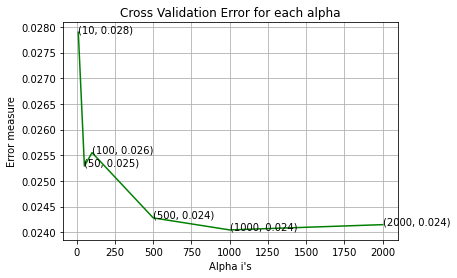

For values of best alpha =  1000 The train log loss is: 0.013435120157712534
For values of best alpha =  1000 The cross validation log loss is: 0.02404392758722389
For values of best alpha =  1000 The test log loss is: 0.025382406589477723
Number of misclassified points  0.3678724708767627
-------------------------------------------------- Confusion matrix --------------------------------------------------


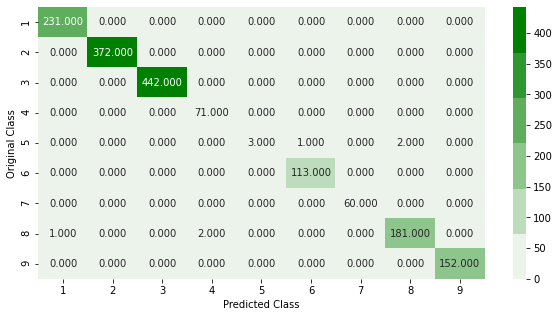

-------------------------------------------------- Precision matrix --------------------------------------------------


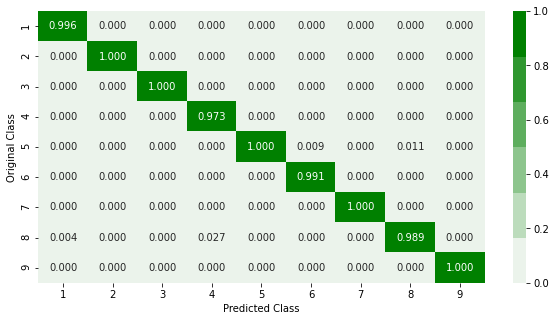

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


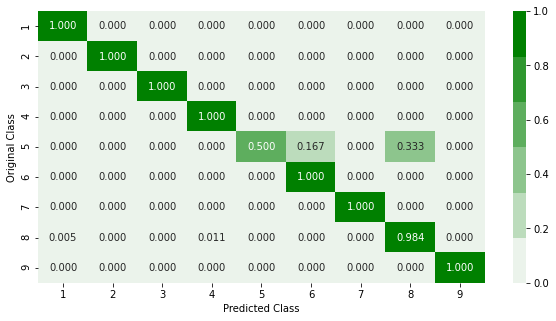

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

log_loss for c =  10 is 0.05849037377512976
log_loss for c =  50 is 0.02741713773438258
log_loss for c =  100 is 0.01925539334152063
log_loss for c =  500 is 0.017573499024288633
log_loss for c =  1000 is 0.017604601515275136
log_loss for c =  2000 is 0.01762325580551631


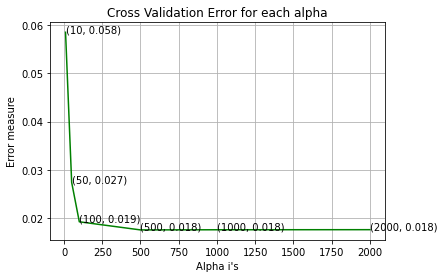

For values of best alpha =  500 The train log loss is: 0.010619921872580955
For values of best alpha =  500 The cross validation log loss is: 0.017573499024288633
For values of best alpha =  500 The test log loss is: 0.013649910888358836
Number of misclassified points  0.1226241569589209
-------------------------------------------------- Confusion matrix --------------------------------------------------


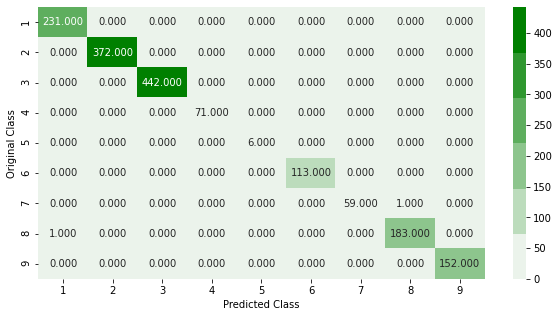

-------------------------------------------------- Precision matrix --------------------------------------------------


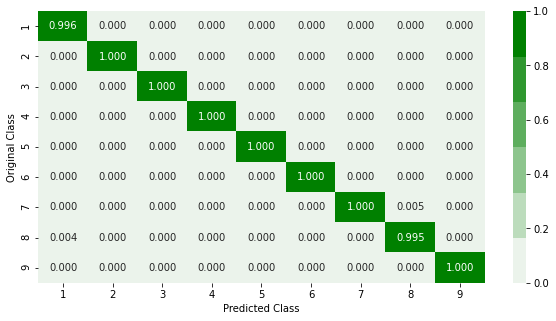

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


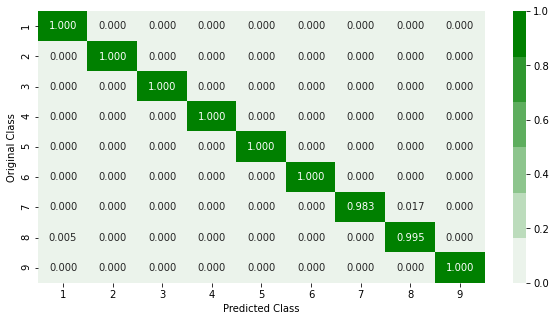

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

In [ ]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  50 | elapsed:  1.6min remaining:  9.8min
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:  3.1min remaining:  8.7min
[Parallel(n_jobs=-1)]: Done  19 out of  50 | elapsed:  6.8min remaining: 11.0min
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:  7.9min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:  8.7min remaining:  5.3min
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed: 12.1min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed: 14.4min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 47.2min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [ ]:
print (random_cfl.best_params_)

{'subsample': 1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1}


In [ ]:
x_cfl=XGBClassifier(n_estimators=200,subsample=1,learning_rate=0.1,colsample_bytree=1,max_depth=3)
x_cfl.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train,y_train)

predict_y = c_cfl.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv)
print ('cv loss',log_loss(y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))

train loss 0.010791527168881864
cv loss 0.018146904737886934
test loss 0.014017224659044626


|Model||Features||Hyperparameter||test loss|
|-----||----||---||-----|
|Random forest||all Byte features+ all asm features with pixel intensity||best alpha = 1000||0.0.025382406589477723|
|Xg-Boost regressor||all Byte features+ all asm features with pixel intensity||best alpha = 500||0.013649910888358836||
|Xg-Boost regressor-with randomcv||all Byte features+ all asm features with pixel intensity+asm opcode feature||best alpha = 200||0.014017224659044626|

For this assignment, I got best solution to get the high configuration in google colab.<br>
(Solution:Open 25 GB RAM GPU notebook file on colab and shift the runtime type to TPU.In this we get <b>35 GB RAM and 107 GB storage space</b> and it has time limit of 12 hours.)<br>
<b>Byte file feature:Unigram,bigram and file size:</b> As file side is 48GB, I have downloaded byte files on Colab only and for the processing of bigrams, I have used multithreading concept. as number of files are 10868, created 22 processes(494 files each process will run parallelly) and total processing time for bigram vectors is reduced from 3 hours to 16 mins only.<br>
Using byte features,got best test loss value <b>0.06937996925615564</b> <br>
<b>For asm pixel intensity feature and asm file features</b>, file size was large(more than 100 GB)so mounted 200 GB google drive(paid subscription which I already have) and downloaded all asm files on mounted Gdrive. Using asm file, extracted png files using multithreading concept(47 mins to create all 10868 images(22 processes, 494 files each process))<br>
Using asm pixel intensity of first 200 pixel and using asm keyword feature,got log loss of <b>0.031523435164007935</b><br>
<b>For all asm feature and byte file features</b>combining both the above feature, loss reduced to <b>0.02993039632795083</b><br>
<b>For all asm feature,byte file features plus asm opcode feature</b>For opcode feature, used same files from gdrive and for the text file opcodes fetching logic, I have used multithreding.In the end combined all opcodes  in one file. this entire <b>process took 43min 11s</b> to get all opcodes.Opcode feature has great impact on loss and finally got test loss <b>0.014017224659044626</b>.